In [1]:
from emulator_utils.pre_process import load_scaler
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import load_mlp, mcdrop_pred

In [2]:
import matplotlib.pylab as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

## Loading the trained models -- pre-processing and the network

In [3]:
scaler = load_scaler('../test/model/input_scale')
scaler_y = load_scaler('../test/model/output_scale')
mlp = load_mlp('../test/model/spec_mlp')

Loading the pre-processing pipeline from: ../test/model/input_scale.pkl
Loading the pre-processing pipeline from: ../test/model/output_scale.pkl
Model loaded from: ../test/model/spec_mlp


In [4]:
# dirIn = '../test/data/sps_ugrizy/'
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/'

mags = np.load(dirIn + 'spec.npy')

ebv = np.load(dirIn + 'ebv.npy')
redshift = np.load(dirIn + 'redshift.npy')
sfh = np.load(dirIn + 'sfh.npy')

sps_inputs = np.concatenate((redshift[np.newaxis, :], ebv[np.newaxis, :], sfh.T), axis=0).T

_, param_test_unscaled, _, mag_test_unscaled = random_holdout(sps_inputs, mags, split_fraction = 0.1)

# Calling the spectral surrogate

In [5]:
pcolor_all, _, _ = mcdrop_pred(param_test_unscaled, mlp, scaler, scaler_y)

## Plotting

(1.0, 20000000.0)

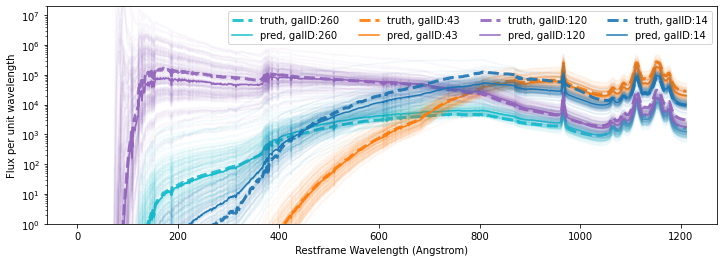

In [6]:
plt.figure(figsize = (12, 4))

galID_arr =  [260, 43, 120, 14]
colorparams = galID_arr
colormap = cm.tab10
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


for galID in galID_arr:

    color = colormap(normalize(galID))
    
    plt.plot(mag_test_unscaled[galID], linestyle='dashed', color = color, label='truth, galID:%d'%galID, alpha=0.9, linewidth = 3)
    
    plt.plot(pcolor_all[:, galID, :].T,  color = color, alpha=0.05)
    plt.plot(np.median(pcolor_all[:, galID, :].T, axis=1),  color = color, alpha=1, label='pred, galID:%d'%galID);


plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
plt.legend(ncol=4)
plt.ylim(1e0, 2e7)